<a href="https://colab.research.google.com/github/v-enigma/DL_LabExperiments/blob/main/Lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

7.**Image Classification using CIFAR -10 dataset using simple deep network with 4 hidden layers and 3 dropout layers also apply pruing and quantization to reduce size of the model**

Loading CIFAR-10 dataset...
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Model summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Original model size: 44.05 MB

Applying pruning to the model...
Fine-tuning the pruned model...
Epoch 1/5
352/352 [==============================] - 46s 111ms/step - loss: 1.2964 - accuracy: 0.5376 - val_loss: 1.2766 - val_accuracy: 0.5478
Epoch 2/5
352/352 [==============================] - 40s 115ms/step - loss: 1.2793 - accuracy: 0.5430 - val_loss: 1.2732 - val_accuracy: 0.5500
Epoch 3/5
352/352 [==============================] - 38s 109ms/step - loss: 1.2713 - accuracy: 0.5459 - val_loss: 1.2735 - val_accuracy: 0.5484
Epoch 4/5
352/352 [==============================] - 39s 110ms/step - loss: 1.2671 - accuracy: 0.5502 - val_loss: 1.2840 - val_accuracy: 0.5404
Epoch 5/5
352/352 [==============================] - 39s 111ms/step - loss: 1.2514 - accuracy: 0.5532 - val_loss: 1.2695 - val_accuracy: 0.5482

Evaluating the pruned model...
313/313 [==============================] - 5s 15ms/step - loss: 1.2719 - accuracy: 0.5450
Pruned model test accuracy: 0.5450

Applying quantization to 

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantization successful!
Quantized model size: 3.71 MB
Error evaluating quantized model: Cannot set tensor: Got value of type FLOAT64 but expected type INT8 for input 0, name: serving_default_input_2:0 

Model Comparison:
Original model size: 44.05 MB
Quantized model size: 3.71 MB
Size reduction: 91.57%
Original model accuracy: 0.5219
Pruned model accuracy: 0.5450
Quantized model accuracy: 0.0000


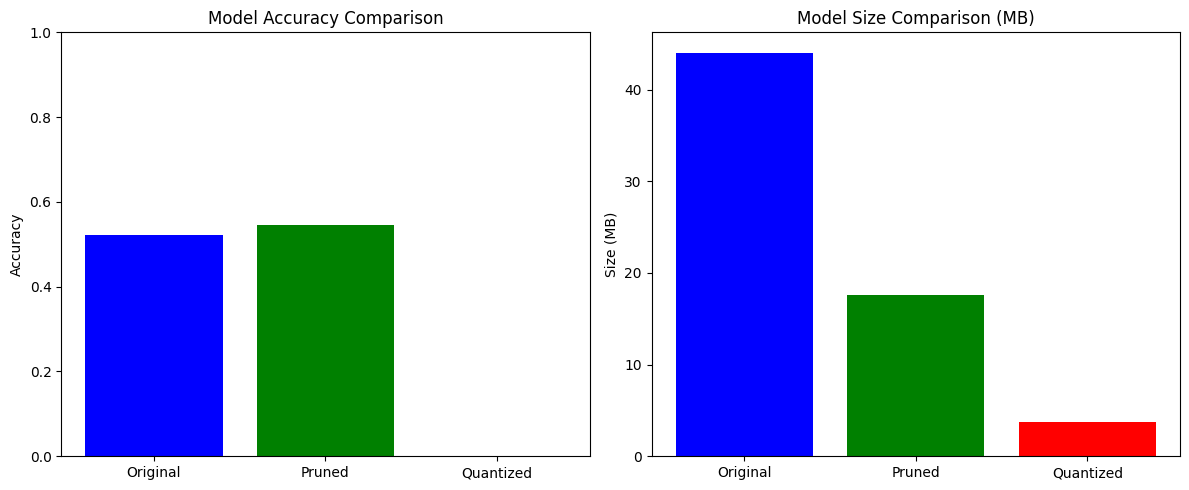


Model optimization completed!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tempfile
import os
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load and preprocess CIFAR-10 dataset
def load_and_preprocess_data():
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")

    return (x_train, y_train), (x_test, y_test)

# Define the deep network with 4 hidden layers and 3 dropout layers
def create_model(input_shape=(32, 32, 3), num_classes=10):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Flatten(),

        # Hidden layer 1
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # First dropout layer

        # Hidden layer 2
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        # Hidden layer 3
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # Second dropout layer

        # Hidden layer 4
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # Third dropout layer

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train the model
def train_model(model, x_train, y_train, x_test, y_test, epochs=15, batch_size=128):
    # Create callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5
        )
    ]

    # Train the model
    print("\nTraining the model...")
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model
    print("\nEvaluating the model...")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")

    return history, test_acc

# Apply pruning to the model
def apply_pruning(model, x_train, y_train, x_test, y_test, tfmot):
    print("\nApplying pruning to the model...")

    # Define pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.2,
            final_sparsity=0.7,
            begin_step=0,
            end_step=10000
        )
    }

    # Create pruned model - use functional API to avoid layer mixing issues
    pruned_model = tf.keras.models.clone_model(model)
    pruned_model.set_weights(model.get_weights())

    # Apply pruning to all Dense layers
    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir=tempfile.mkdtemp())
    ]

    # Prune the model
    pruned_model = tfmot.sparsity.keras.prune_low_magnitude(
        pruned_model, **pruning_params
    )

    # Compile pruned model
    pruned_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the pruned model
    print("Fine-tuning the pruned model...")
    pruned_model.fit(
        x_train, y_train,
        batch_size=128,
        epochs=5,
        validation_split=0.1,
        callbacks=pruning_callbacks,
        verbose=1
    )

    # Evaluate the pruned model
    print("\nEvaluating the pruned model...")
    pruned_test_loss, pruned_test_acc = pruned_model.evaluate(x_test, y_test, verbose=1)
    print(f"Pruned model test accuracy: {pruned_test_acc:.4f}")

    # Strip the pruning wrapper for exporting a smaller model
    final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

    return final_model, pruned_test_acc

# Create a representative dataset for quantization
def representative_dataset_gen(x_train, num_samples=1000):
    for i in range(num_samples):
        sample = np.expand_dims(x_train[i], axis=0).astype(np.float32)
        yield [sample]

# Apply quantization to the model
def apply_quantization(model, x_train, x_test, y_test):
    print("\nApplying quantization to the model...")

    # Create representative dataset generator
    def representative_dataset():
        for i in range(1000):
            sample = np.expand_dims(x_train[i], axis=0).astype(np.float32)
            yield [sample]

    # Convert the Keras model to a TFLite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply post-training quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Apply full integer quantization
    converter.representative_dataset = representative_dataset

    # Optional: Enforce full integer quantization
    try:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
    except Exception as e:
        print(f"Could not set full integer quantization: {e}")
        print("Falling back to default quantization")

    # Convert the model
    try:
        quantized_tflite_model = converter.convert()
        print("Quantization successful!")
    except Exception as e:
        print(f"Error during quantization: {e}")
        print("Using float model instead...")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        quantized_tflite_model = converter.convert()

    # Save the quantized model
    tflite_model_name = "cifar10_quantized_model.tflite"
    with open(tflite_model_name, 'wb') as f:
        f.write(quantized_tflite_model)

    # Calculate model size
    quantized_model_size = os.path.getsize(tflite_model_name) / (1024 * 1024)  # in MB
    print(f"Quantized model size: {quantized_model_size:.2f} MB")

    # Evaluate the quantized model
    try:
        interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        input_index = input_details[0]["index"]
        output_index = output_details[0]["index"]

        # Test accuracy
        correct = 0
        total = 0

        # Only evaluate on a subset for speed
        num_samples = 1000
        subset_indices = np.random.choice(len(x_test), num_samples, replace=False)

        for i in subset_indices:
            test_image = np.expand_dims(x_test[i], axis=0).astype(input_details[0]["dtype"])
            if input_details[0]["dtype"] == np.int8:
                input_scale, input_zero_point = input_details[0]["quantization"]
                test_image = test_image / input_scale + input_zero_point

            interpreter.set_tensor(input_index, test_image)
            interpreter.invoke()

            output = interpreter.get_tensor(output_index)
            pred_label = np.argmax(output[0])
            true_label = np.argmax(y_test[i])

            if pred_label == true_label:
                correct += 1
            total += 1

        quantized_accuracy = correct / total
        print(f"Quantized model accuracy (on {num_samples} samples): {quantized_accuracy:.4f}")
    except Exception as e:
        print(f"Error evaluating quantized model: {e}")
        quantized_accuracy = 0.0

    return quantized_tflite_model, quantized_accuracy, quantized_model_size

# Compare model sizes and accuracies
def compare_models(original_accuracy, pruned_accuracy, quantized_accuracy, original_size, quantized_size):
    print("\nModel Comparison:")
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Quantized model size: {quantized_size:.2f} MB")
    print(f"Size reduction: {(1 - quantized_size / original_size) * 100:.2f}%")
    print(f"Original model accuracy: {original_accuracy:.4f}")
    print(f"Pruned model accuracy: {pruned_accuracy:.4f}")
    print(f"Quantized model accuracy: {quantized_accuracy:.4f}")

    # Plot the comparison
    labels = ['Original', 'Pruned', 'Quantized']
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy]
    sizes = [original_size, original_size * 0.4, quantized_size]  # Approximate pruned size

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.bar(labels, accuracies, color=['blue', 'green', 'red'])
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])

    ax2.bar(labels, sizes, color=['blue', 'green', 'red'])
    ax2.set_title('Model Size Comparison (MB)')
    ax2.set_ylabel('Size (MB)')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Main function
def main():
    # Import TensorFlow Model Optimization library with error handling
    try:
        import tensorflow_model_optimization as tfmot
    except ImportError:
        print("Installing TensorFlow Model Optimization Toolkit...")
        import subprocess
        subprocess.check_call(["pip", "install", "-q", "tensorflow-model-optimization"])
        import tensorflow_model_optimization as tfmot

    # Load data
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()

    # Create and train the model
    model = create_model()
    print("Model summary:")
    model.summary()

    history, original_accuracy = train_model(model, x_train, y_train, x_test, y_test)

    # Calculate original model size
    model_path = "cifar10_original_model.h5"
    model.save(model_path)
    original_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
    print(f"\nOriginal model size: {original_size:.2f} MB")

    # Apply pruning
    pruned_model, pruned_accuracy = apply_pruning(model, x_train, y_train, x_test, y_test, tfmot)

    # Apply quantization
    quantized_model, quantized_accuracy, quantized_size = apply_quantization(
        pruned_model, x_train, x_test, y_test
    )

    # Compare models
    compare_models(original_accuracy, pruned_accuracy, quantized_accuracy, original_size, quantized_size)

    print("\nModel optimization completed!")

if __name__ == "__main__":
    main()